In [15]:
import re
from gensim.corpora import Dictionary
from datetime import datetime, timedelta
import numpy as np
from string import punctuation
import pandas as pd
from nltk.corpus import stopwords
import itertools
from six import iteritems
from gensim import corpora, models
import gensim
import pyLDAvis
import pyLDAvis.gensim
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
#get tweets from past 7 days
in_date=pd.datetime.today()-timedelta(days=1)
in_date=in_date.strftime('%Y-%m-%d')
week=pd.read_csv('tweet_save'+in_date+'.csv')
week.text=week.text.str.lower()
week=week[week['dtime']<(pd.to_datetime(in_date)+timedelta(days=1)).strftime('%Y-%m-%d')]

In [57]:
# import stop words and append on as needed 
stops=stopwords.words('english')
stops.append('rt')
stops.append('qt')
stops.append('&amp;')
stops.append('-')
stops.append(':')
stops.append(';')
stops.append('|')
stops.append('#')
stops.append('+')
stops.append('--')
stops.append('–')
stops.append('→')
stops.append('1')
stops.append('2')
stops.append('3')
stops.append('4')
stops.append('5')
stops.append('6')
stops.append('7')
stops.append('8')
stops.append('9')
stops.append(str("it'"+'s'))
stops.append(',')
stops.append('?')
stops.append("'")
stops.append('"')
stops.append(',')
stops.append('!')
stops.append('amp')
stops.append("'")
stops.append("$")
stops.append("&")
stops.append("/")
stops.append('i')
stops.append('w')
stops.append('m')
stops.append('de')
stops.append("w/")

In [58]:
#removes links, trailing punctuation, and stop words 
no_links=[]
c=0
for j in range(0,len(week)):
    try:
        t=re.sub(r"http\S+", "", week.text.iloc[j])
        #t=t.rstrip(punctuation)
        t=t.split()
    except:
        q=week.text.iloc[j]
        print(j)
        print(q)
    no_links.append(t)
texts=[[j for j in i if not j in stops] for i in no_links]
texts=[[j.rstrip(punctuation) for j in i]for i in texts]

[['@thehill',
  '50',
  'medicaid',
  'directors',
  'come',
  'gop',
  'bill',
  'repeal',
  'obamacare'],
 ['@plsimpeach',
  '@repcohen',
  'hit',
  'bullseye',
  '@tavissmileyshow',
  'tonight',
  'calling',
  '45',
  '"seven',
  'deadly',
  'sins',
  '#unfit'],
 ['icymi',
  'joined',
  '@tavissmiley',
  '@pbs',
  '(@wkno_tv',
  '#memphis',
  'talk',
  '#impeachment',
  '#trump',
  '#impeachtrump',
  'watch'],
 ['@bannonfellates',
  'truth',
  '@dc_resister_bee',
  '@missvikkiv',
  '@realdonaldtrump',
  'real',
  'president',
  'would',
  'say',
  'russia',
  'interfered',
  'election',
  'must',
  'unite',
  'stop',
  'americans'],
 ['@thehill',
  'kobe',
  'bryant',
  'trump',
  '"can\'t',
  'possibly',
  'make',
  'america',
  'great',
  '"inspires',
  'hatred'],
 ['@warriorspr', 'statement', 'golden', 'state', 'warriors'],
 ['absurd',
  'many',
  'people',
  'trump',
  'biased',
  'against',
  '@thehill',
  'megyn',
  'kelly',
  '"absurd',
  'many',
  'reporters',
  'biased',
  

In [59]:
#series of lda models checking consistency against a holdout set
random.seed(22)
train_set = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_set = [x for x in list(range(0,len(texts))) if x not in train_set]

train_texts = [texts[i] for i in train_set]
test_texts = [texts[i] for i in test_set]
print(len(train_texts),len(test_texts))

topicnums = [1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

dictionary = corpora.Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

#runs len(topicnums) ldas
ldamodels_bow = {}
for i in topicnums:
    random.seed(22)
    ldamodels_bow[i] = models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary, passes=1,alpha='auto')
    ldamodels_bow[i].save('ldamodels_bow_'+str(i)+'.lda')

def intra_inter(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[dictionary.doc2bow(tokens[:int(len(tokens)/2)])] for tokens in test_docs]
    part2 = [lda_model[dictionary.doc2bow(tokens[int(len(tokens)/2):])] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(22)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts
#consistency check
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter(lda_model, dictionary, test_texts)

corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]

diff = [a - b for a, b in zip(corresp_parts, random_parts)]
#maximum difference between cosine similarity and random parts similarity
topic_k=topicnums[diff.index(max(diff))]

8232 1000


/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


In [60]:
#create the dictionary for final LDA using full dataset
dictionary = corpora.Dictionary(texts) 
#removes all words that appear once/stops again
stop_ids = [dictionary.token2id[stopword] for stopword in stops if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
dictionary.filter_tokens(stop_ids + once_ids)  # remove stop words and words that appear only once
dictionary.compactify()	
#creates corpus for LDA
corpus = [dictionary.doc2bow(text) for text in texts]
#runs LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=topic_k,passes=1,alpha='auto')

#file for LDA viz
LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary,R=15)
freq=LDAvis_prepared[1]
freq['Date']=in_date

#assign most probable topic as topic for each tweet
lda_topic_assignment = [max(p,key=lambda item: item[1]) for p in ldamodel[corpus]]
top_list = [x[0] for x in lda_topic_assignment]
week['lda_topic']=top_list
week['model']=in_date

/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


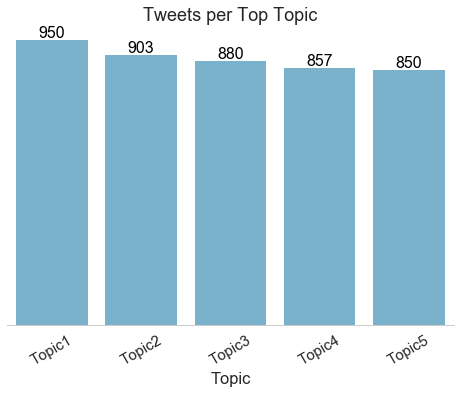

/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


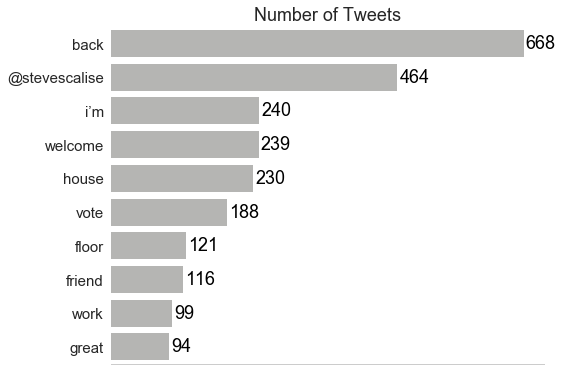

/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


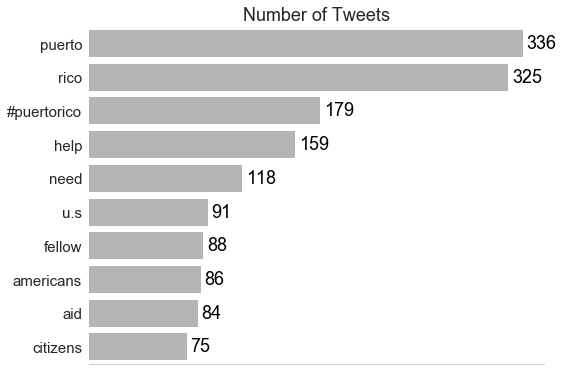

/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


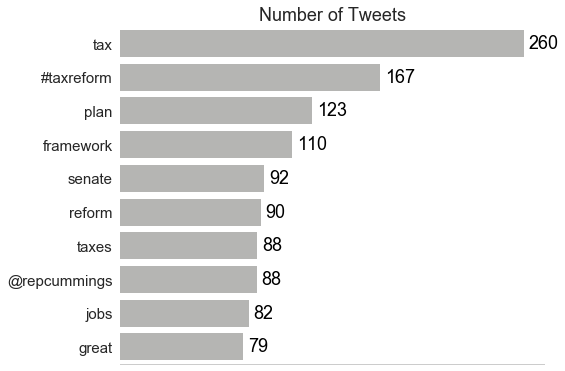

/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


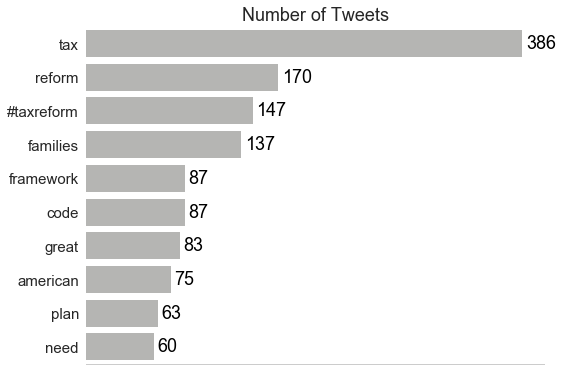

/Applications/anaconda/envs/my_projects_env/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


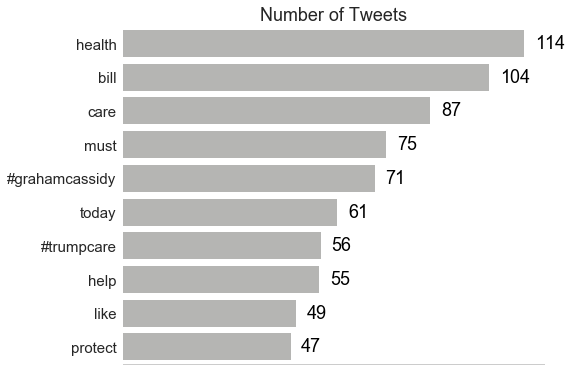

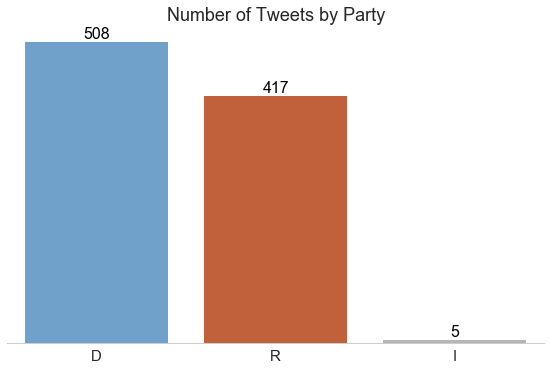

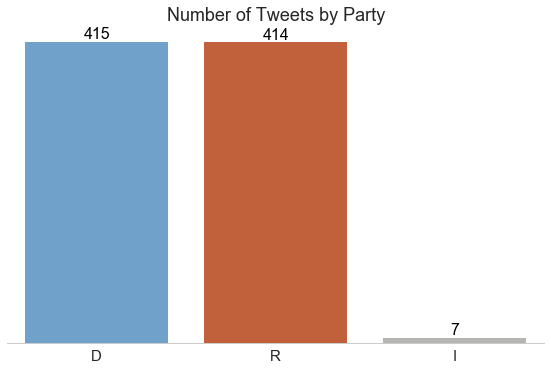

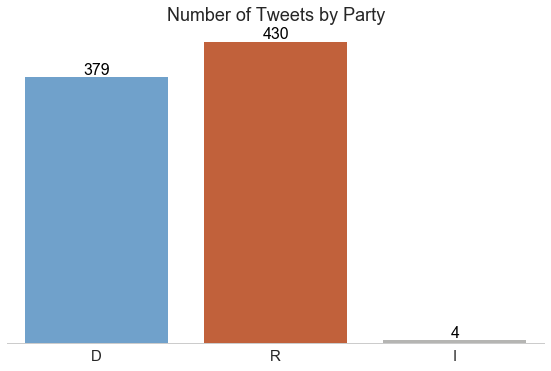

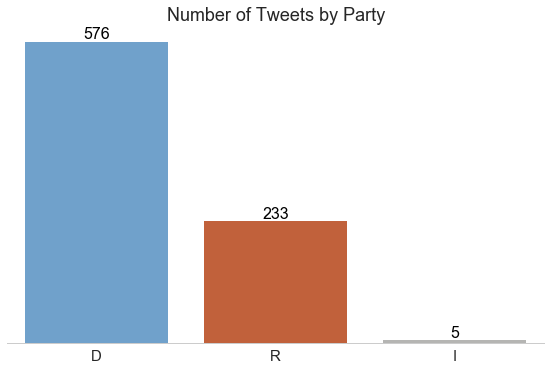

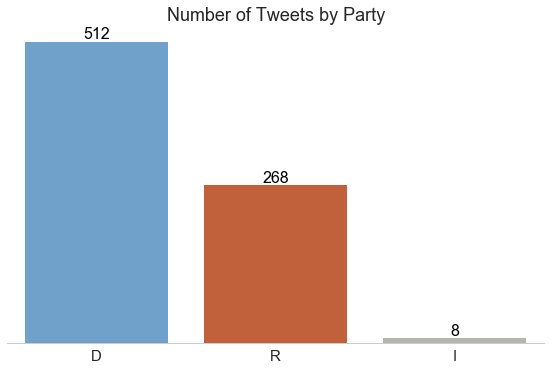

lda_topic    0    1    2    3    4    5    6    7    8    9    10   11
dates                                                                 
2017-09-22   86  115   91   89  162  115  214  116   55   91   93  119
2017-09-23   26   57   39   40   55   61   47   31   19   35   27   43
2017-09-24   29   47   43   35   60   40   36   31   37   60   35   17
2017-09-25   92  150   87  111  206  120  154  164   73  146  112   89
2017-09-26   10   17    7   13   40   20   19   19    9   13   12   12
2017-09-27  286  135  230  328  147  171  169  266  181  257  154  361
2017-09-28  200  429  178  287  129  178  154  223  116  255  168  239


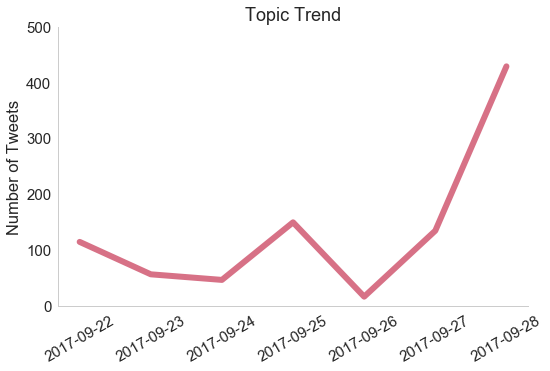

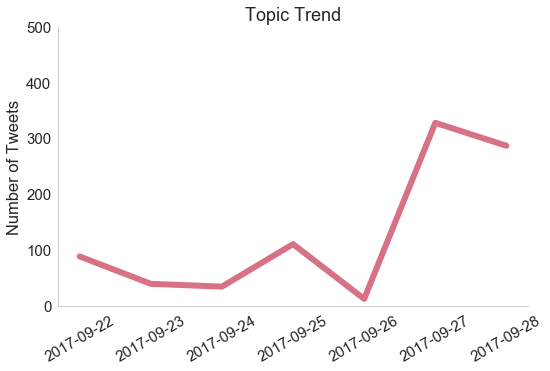

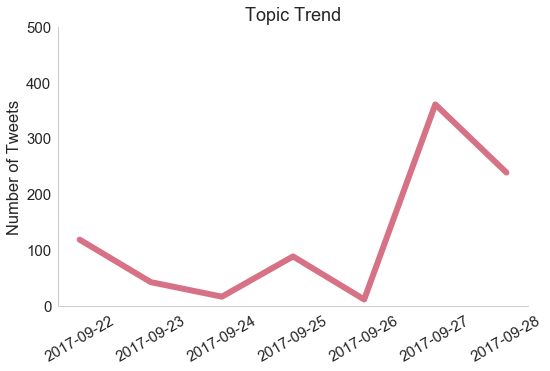

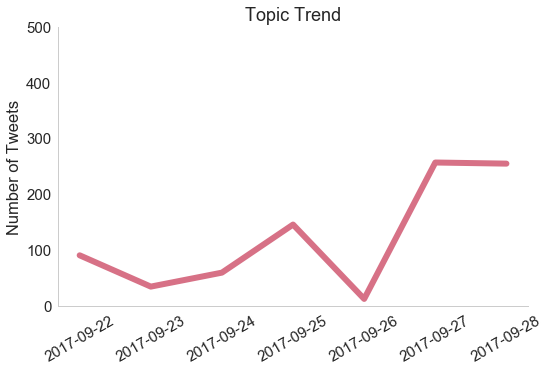

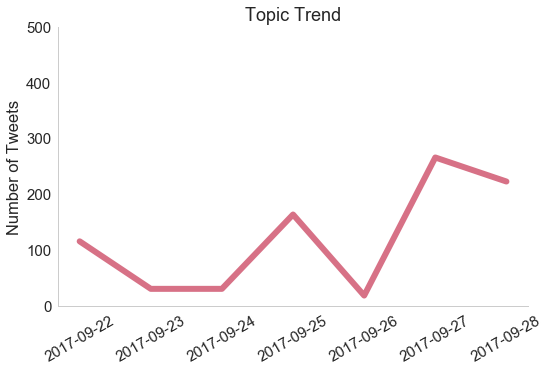

In [61]:
#prepares arrays for visualizations
y=week['lda_topic'].value_counts().tolist()
x=week['lda_topic'].value_counts().index.tolist()

plot_top=['Topic'+str(i) for i in x]

odf = pd.DataFrame({'x':x,
                   'y':y,
                   'topic':plot_top})

df=odf.sort_values(by='y',ascending=False)[:5]

#top 5 topics
slist=df['x'].tolist()
plot_top
df['topic']=['Topic'+str(i) for i in range(1,6)]
df['x_sort']=[i for i in range(0,5)]

cf=freq[freq.Category!='Default']

flatui = ['#61A2DA','#D75725','#B5B5B3']

#overall topic breakdown
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
ax = sns.barplot(x='x_sort', y="y",color='#6CB7DA', data=df)
ax.set(xlabel='Topic', ylabel='',title='Tweets per Top Topic')
ax.set_xticklabels(labels=df['topic'],rotation=30)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=16, color='black', ha='center', va='bottom')
sns.despine(left=True)
ax.set(yticklabels=[])
ax.grid('off')
#plt.savefig("Topics_"+str(in_date)+".jpg",dpi=300)
plt.show()
plt.close()

#arrays for frequent word plots
dov_list=[]
for i in range(1,6):
    j=cf[cf.Category=='Topic'+str(i)].sort_values('Freq',ascending=[False]).head(10)['Term'].tolist()
    dov_list.append(j)
dot_list=[]
for i in range(1,6):
    j=cf[cf.Category=='Topic'+str(i)].sort_values('Freq',ascending=[False]).head(10)['Freq'].tolist()
    dot_list.append(j)

#plots for frequent words    
for i in range(0,len(slist)):
    top='Topic '+str(i+1)
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    ax=sns.barplot(x=dot_list[i], y=dov_list[i],color='#B5B5B3')
    ax.set(xlabel='', ylabel='',title='Number of Tweets')
    ax.set_xticklabels(labels=df['topic'],rotation=30)
    for p in ax.patches:
        ax.text(p.get_width()+3, p.get_height()/1.2 + p.get_y(), '%d' % int(p.get_width()), 
                fontsize=18, color='black', ha='left', va='bottom')
    sns.despine(left=True)
    ax.set(xticklabels=[])
    ax.grid('off')
    plt.tight_layout()
    #plt.savefig('top+'_'+str(in_date)+'.jpg',dpi=300)
    plt.show()
    plt.close()

#plots for party breakdown of tweets    
week['party'] = pd.Categorical(week['party'], ["D", "R", "I"])
j=1
for i in slist:
    cdf=week[week['lda_topic']==i]
    cdf=cdf.sort_values(by='party')
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    sns.set_palette(flatui)
    ax = sns.countplot(x='party', data=cdf)
    ax.set(xlabel='', ylabel='',title='Number of Tweets by Party')
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=16, color='black', ha='center', va='bottom')
    sns.despine(left=True)
    ax.set(yticklabels=[])
    ax.grid('off')
    plt.tight_layout()
    #plt.savefig('split'+str(j)+'_'+str(in_date)+'.jpg',dpi=300)
    plt.show()
    plt.close()
    j=j+1

#week trend plots    
week['dtime']=pd.to_datetime(week['dtime'],format='%Y-%m-%d')

dates=[]
for i in range(0,len(week)):
    dates.append(week.dtime.iloc[i].date())
week['dates']=dates
week['lda_topic']=week['lda_topic'].astype('category')
line=week.groupby(['dates','lda_topic']).size().reset_index(name='counts')
line.dates.astype('category')
dl=line.pivot(index='lda_topic',columns='dates',values='counts').transpose()
print(dl)
j=1
for i in slist:
    ax=plt.plot((dl[i]),color ='#D77186', linewidth=6)
    plt.xticks(rotation=30)
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    sns.despine(right=True)
    plt.ylim([0,500])
    plt.ylabel('Number of Tweets')
    plt.title('Topic Trend')
    plt.grid(False)
    plt.xlabel('')
    plt.tight_layout()
    #plt.savefig('trend'+str(j)+'_'+str(in_date)+'.jpg',dpi=300)
    plt.show()
    plt.close()
    j=j+1